In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from gdtw import gdtw

import xarray as xr

from tqdm import tqdm
from praatio import textgrid

from scipy import signal

# import sparc
from sparc import sparc

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import random 

from datetime import datetime

import soundfile


importing Latane gdtw
importing Latane gdtw


/Users/ly546/Documents/conda-miniforge3/envs/aligner/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ARTIC_LABELS = ['T3','T2','T1','JAW','UL','LL']
SENSOR_LABELS = [f"{s}_{ax}" for s in ARTIC_LABELS for ax in ['x','y']]

EMA_META = pd.read_csv('./channel_names_norm.csv')
# trim whitespace from column 'name' and 'id'
EMA_META['name'] = EMA_META['name'].str.strip()
EMA_META['id'] = EMA_META['id'].str.strip()

index_csv = "/Users/ly546/Documents/data/mngu0_segment_index.csv"
# mngu0_ema_dir   = "/Users/ly546/Documents/data/mngu0_s1_ema_csv"
mngu0_ema_dir = "/Volumes/Nexus4/Users/lbullock/20251120_mngu0-sparc-inversion/data/mngu0_s1_ema_csv"
sparc_ema_dir = "/Volumes/Nexus4/Users/lbullock/20251120_mngu0-sparc-inversion/data/mngu0_s1_sparc2"

In [3]:
DEVICE = "cpu" # IF YOU HAVE NVIDIA GPU: DEVICE="cuda", otherwise: DEVICE="cpu"
FS_SPARC_CODE = 50
FS_MNGU0 = 200
FS_SPARC_AUDIO = 16000
coder = sparc.load_model("en", device=DEVICE, use_penn=False)

f = Path('/Users/ly546/Documents/data/mngu0_s1_wav_16kHz_1.1.0/mngu0_s1_0001.wav')

load_model v3
load_model v3


/Users/ly546/Documents/conda-miniforge3/envs/aligner/lib/python3.13/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [4]:

c = {}
# c["code_orig"] = copy.deepcopy(codes[0])
c["code_orig"] = coder.encode(f)
# resynthesize
wav = coder.decode(**c["code_orig"])
from IPython.display import Audio
Audio(wav, rate=FS_SPARC_AUDIO)


/Users/ly546/Documents/conda-miniforge3/envs/aligner/lib/python3.13/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


(0.0, 3.2)

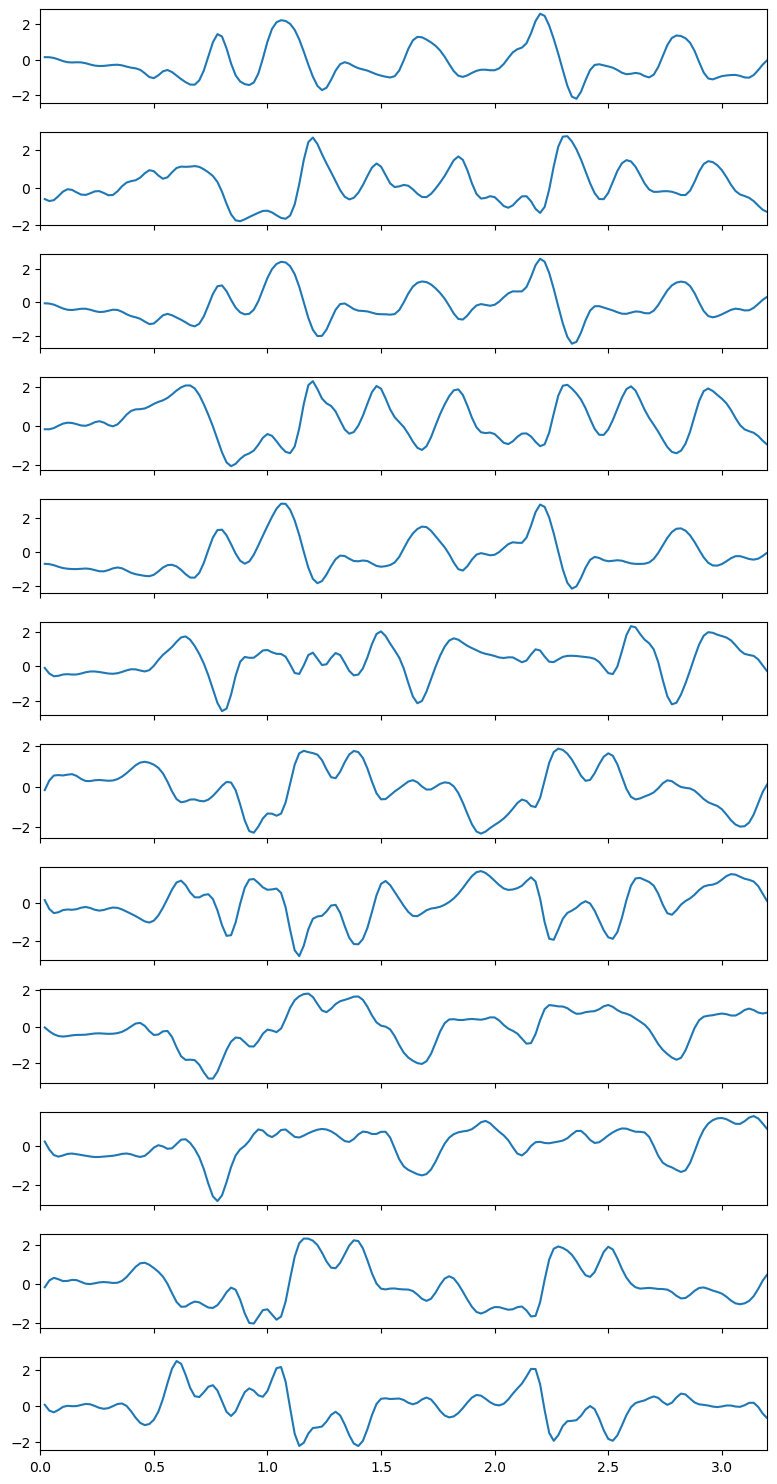

In [5]:

# soundfile.write((f.parent / (f.stem + "_resynth" + f.suffix)), wav, coder.sr)

c["fname"] = f.stem
c["loudness"] = np.squeeze(c["code_orig"]['loudness'])
c["ema"] = np.squeeze(c["code_orig"]['ema']) 
c["pitch"] = np.squeeze(c["code_orig"]['pitch']) 
c["periodicity"] = np.squeeze(c["code_orig"]['periodicity']) 

c["time"] = np.arange(1, c["ema"].shape[0]+1) / FS_SPARC_CODE  

fig, axs = plt.subplots(12, 1, figsize=(8, 15), sharex=True)
fig.tight_layout()
for i in range(len(axs)):
    axs[i].plot(c["time"], c["ema"][:, i])
axs[0].set_xlim([0, 3.2])


In [6]:
SENSOR_LABELS
SPARC_LABELS = ["ULX", "ULY", "LLX", "LLY", "LIX", "LIY", "TTX", "TTY", "TBX", "TBY", "TDX", "TDY"]

mngulabels02sparclabels = {
'T3_x': 'TDX',  
 'T3_y': 'TDY',  
 'T2_x': 'TBX',  
 'T2_y': 'TBY',  
 'T1_x': 'TTX',  
 'T1_y': 'TTY',  
 'JAW_x': 'LIX',  
 'JAW_y': 'LIY',  
 'UL_x': 'ULX',  
 'UL_y': 'ULY',  
 'LL_x': 'LLX',  
 'LL_y': 'LLY'
 }  


# Helper functions

In [7]:

# --------------------------------------------------
# 1️⃣ Query function
# --------------------------------------------------
def query_segments(index_csv, query_str):
    """
    Simple query wrapper around the segment index table.

    Parameters
    ----------
    index_csv : str or Path
        Path to the CSV index (built previously).
    query_str : str
        Pandas-style query string, e.g. 'segment_tier=="PHONEME" and label=="G"'

    Returns
    -------
    df : pd.DataFrame
        Filtered segment rows.
    """
    df = pd.read_csv(index_csv)
    df_result = df.query(query_str).copy()
    print(f"✅ Found {len(df_result)} segments matching query.")
    return df_result


In [9]:

# --------------------------------------------------
# 2️⃣ Visualization function
# --------------------------------------------------
def plot_segments(data_da,
                  show_individual=False,
                  fs=FS_SPARC_CODE, 
                  ylims=[-0.75, 0.75]):
    """
    Plot articulatory trajectories for a set of queried segments.

    Parameters
    ----------
    df_result : DataFrame
        Output of query_segments(), each row = one segment instance.
    ema_dir : Path
        Directory containing *_ema.csv files for each utterance.
    time_lock : {"onset","offset","middle"}
        Reference point for alignment.
    WINDOW : tuple
        Time window (s) relative to the lock point, e.g. (-0.1, 0.2).
    show_individual : bool
        If True, plot individual traces.
    fs : int
        Sampling rate of EMA (Hz).
    """

    # chans = data_da.coords['chan']
    
    # compute mean and SEM
    mean_traj = data_da.mean(dim='rep').values
    sem_traj = data_da.std(dim='rep').values #  / np.sqrt(data_stack.shape[0])

    # ---- plotting ----
    fig, axes = plt.subplots(len(data_da.coords['chan']), 1, figsize=(8, 15), sharex=True)
    for i, (ax, ch) in enumerate(zip(axes, data_da.coords['chan'].values)):
        if show_individual:
            # select at most 20 random trials to plot
            if data_da.coords['rep'] > 20:
                idx = np.random.choice(data_da.coords['rep'], 20, replace=False)
            else:
                idx = np.arange(data_da.coords['rep'])
            for trial in data_da:
                ax.plot(data_da.coords['time'], trial, color="gray", alpha=0.3)
        ax.plot(data_da.coords['time'], mean_traj[i, :], color="blue", lw=2)
        ax.fill_between(
            data_da.coords['time'],
            mean_traj[i, :] - sem_traj[i, :],
            mean_traj[i, :] + sem_traj[i, :],
            color="blue", alpha=0.3
        )
        ax.axvline(0, color="black", ls="--", lw=0.8)
        # ax.axvline(np.mean(df_result.), color="black", ls="--", lw=0.8)
        ax.set_ylabel(ch)
        # ax.set_ylim(ylims)  # auto
    axes[-1].set_xlabel("Time (s)")
    # plt.suptitle(f"{(data_da.coords['rep'])} tokens | lock={time_lock} | window={WINDOW}")
    plt.tight_layout()
    plt.show()


✅ Found 1 segments matching query.
      utterance_id segment_tier                   segment_id  \
542  mngu0_s1_0011    UTTERANCE  mngu0_s1_0011_utterance-001   

                                         label  start_time  end_time  \
542  <eps> we are nowhere near there yet <eps>         0.0  2.416375   

     duration                                      textgrid_path  
542  2.416375  /Users/ly546/Documents/data/mngu0_s1_TextGrid/...  
Removing 0 out of 1 segments with NaN values.


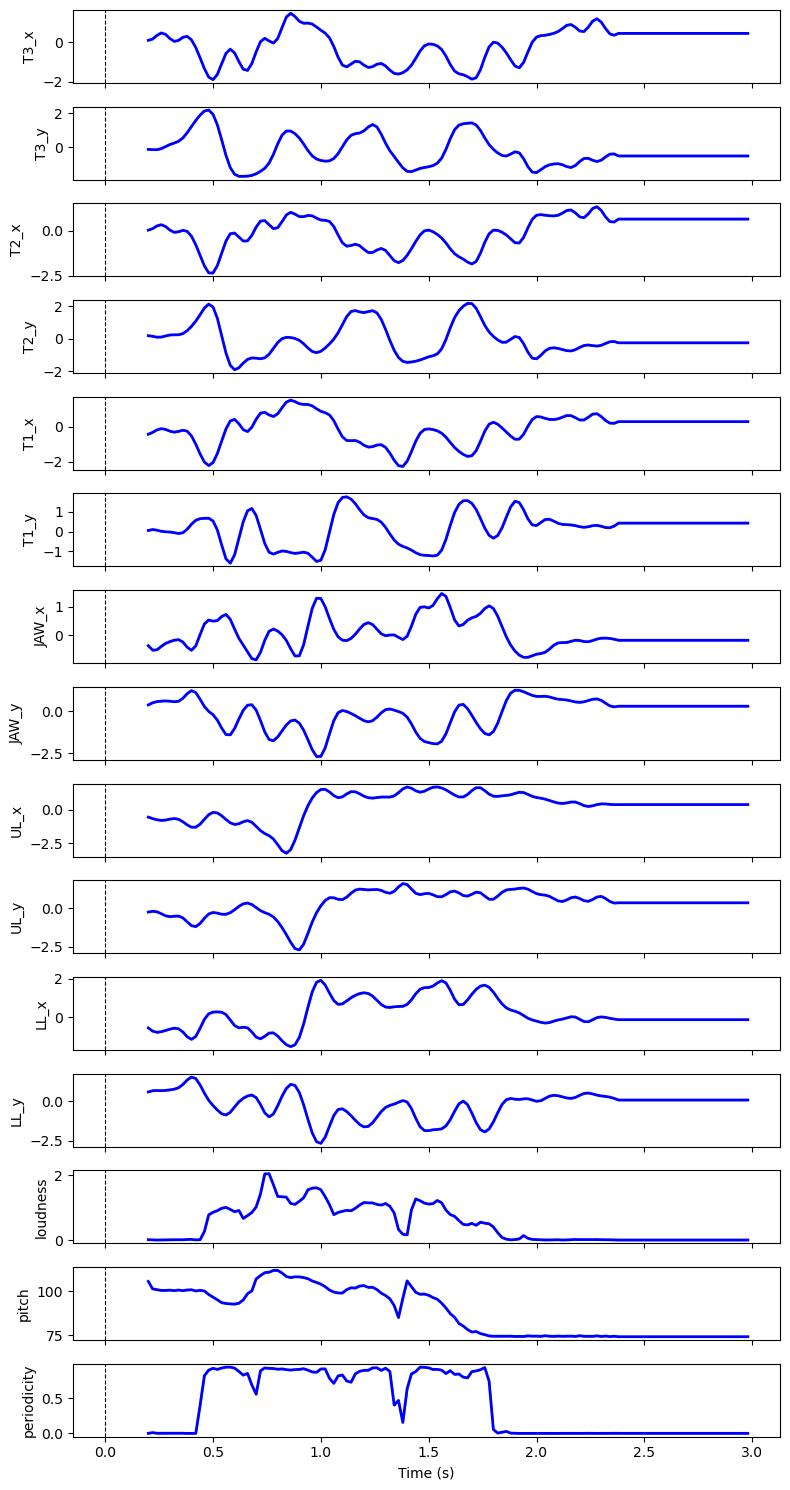

In [11]:
def load_ema_traces(df_result, ema_source="mngu0", time_lock="middle", WINDOW=[-0.5, 0.5], fs_out=FS_SPARC_CODE, chans = SENSOR_LABELS, remove_nan=True): 
    # ema_source specifies where we load the ema from: mngu0 or sparc
    
    fs_in = FS_MNGU0 if ema_source=="mngu0" else FS_SPARC_CODE
    
    if ema_source=="sparc":
        chans_voice = ['loudness', 'pitch', 'periodicity'] 
        chans = chans  + chans_voice
    #     chans_tmp = [mngulabels02sparclabels[s] for s in SENSOR_LABELS] + chans_voice
    # chans_tmp = chans
    # print(chans_tmp)

    # collect trajectories
    aligned_traces = []

    for _, row in df_result.iterrows():
        utt = row['utterance_id']
        # ema_path = Path(mngu0_ema_dir) / f"{utt}_ema.csv"
        ema_path = Path(mngu0_ema_dir) / f"{utt}_ema.csv" if ema_source=="mngu0" else Path(sparc_ema_dir) / f"{utt}-resynth-ema.csv"
        if not ema_path.exists():
            continue
        ema = pd.read_csv(ema_path)
        t = ema['time'].to_numpy()

        # determine time lock
        if time_lock == "onset":
            t0 = row['start_time']
        elif time_lock == "offset":
            t0 = row['end_time']
        elif time_lock == "middle":
            t0 = (row['start_time'] + row['end_time']) / 2
        else:
            assert False, "Invalid time_lock value."

        # extract window around t0
        mask = (t >= t0 + WINDOW[0]) & (t <= t0 + WINDOW[1])
        # t_new =  np.arange(WINDOW[0], WINDOW[1], fs_in)
        t_new = t[mask]
        t_new = t_new - t0

        if not np.any(mask):
            continue

        segment = ema.loc[mask, chans].to_numpy()
        aligned_traces.append([segment, t_new])

    if len(aligned_traces) == 0:
        print("⚠️ No matching segments found with available EMA data.")
        return

    # interpolate to common grid
    # n_samples = max(len(seg) for (seg, t_new) in aligned_traces)
    t_common = np.arange(WINDOW[0], WINDOW[1], 1/fs_out)
    data_stack = np.zeros((len(aligned_traces), len(chans), len(t_common)))

    for i, (seg, t_new) in enumerate(aligned_traces):
        for j in range(len(chans)):
            data_stack[i, j, :] = np.interp(
                t_common,
                t_new,
                seg[:, j]
            )
    
    
    da = xr.DataArray(data_stack, coords={"time": t_common, "chan": chans}, dims=("rep","chan","time"))
    if remove_nan:
        idxs_rep_nan = da.isnull().any(dim=('time','chan'))
        print(f'Removing {idxs_rep_nan.sum().item()} out of {len(da.rep)} segments with NaN values.')
        da = da.isel(rep=~idxs_rep_nan)
    return da

# df_result = query_segments(index_csv, f'segment_tier=="WORD" and label=="very"')
# df_result = query_segments(index_csv, f'segment_tier=="UTTERANCE" and label=="very"')
df_result = query_segments(index_csv, f'segment_id=="mngu0_s1_0011_utterance-001"')
print(df_result)
# df_result = df_result.iloc[[1]]
ema_da = load_ema_traces(df_result, ema_source="sparc", time_lock='onset', WINDOW=[0.2, 3], remove_nan=True)

plot_segments(ema_da)

In [12]:
# replay loaded traces with sparc
def ema_da_to_sparc_code(ema_da): 
    ema_da_trans = ema_da.transpose('rep', 'time', 'chan')

    # reversed_dict = {value: key for key, value in mngulabels02sparclabels.items()}
    # ema_da_trans = ema_da_trans.reindex(chan=[reversed_dict[l] for l in SPARC_LABELS]+['pitch', 'loudness', 'periodicity'])

    c1 = {}
    c1["loudness"] = ema_da_trans.sel(chan=['loudness']).values
    c1["pitch"] = ema_da_trans.sel(chan=['pitch']).values
    c1["periodicity"] = ema_da_trans.sel(chan=['periodicity']).values
    c1["ema"] = ema_da_trans.sel(chan=SENSOR_LABELS).values
    c1["spk_emb"] = c["code_orig"]["spk_emb"]

    return c1

c1 = ema_da_to_sparc_code(ema_da)
wav = coder.decode(**c1)

Audio(wav, rate=FS_SPARC_AUDIO)

# Overview of MNGU database

In [ ]:
# save to disk to manually annotate vowels and consonants
df_result = query_segments(index_csv, 'segment_tier=="PHONE"') 
df_result = df_result['label']
df_result = df_result.drop_duplicates()
df_result.to_csv('./MFA-phone-map_orig.csv', index=False)

phone_map_df = pd.read_csv('./MFA-phone-map.csv')
# VOWELS = set(['a', 'ɑː' 'aj', 'ɐ', 'ə', 'ej', 'ɜ', 'ɜː', 'ɪ'])
VOWELS = set(phone_map_df['label'][phone_map_df['VC']=="V"])
IGNORE = set(['sil'])
VOWELS


In [ ]:

# inspect index--plot most frequent words and phonemes
df = pd.read_csv(index_csv)
df_word = df[df['segment_tier'] == 'WORD']
# df_phoneme = df[df['segment_tier'] == 'PHONE']

# remove any words that contain non-alphabetic characters
df_word = df_word[df_word['label'].str.isalpha()]

df_word['label'].value_counts() # .head(20).plot(kind='bar', figsize=(10,4), title='Top 20 words')

In [ ]:
# plot durations of the top 10 words--one for each word 
# top_words = df_word['label'].value_counts().head(20).index.tolist()
top_words = ['people', 'more', 'two', 'would', 'said', 'but']
df_word[df_word['label'].isin(top_words)]

fig, axs = plt.subplots(5, 2, figsize=(6,10), tight_layout=False)
for word, ax  in zip(top_words, axs.ravel()):
    df_word[df_word['label'] == word]['duration'].hist(bins=20, alpha=0.5, label=word, ax=ax)
    ax.set_title(f'{word}')
plt.legend()

In [ ]:
# query all tokens of the word "GREAT"
# df_result = query_segments(index_csv, 'segment_tier=="WORD" and label=="people"') 
df_result = query_segments(index_csv, 'segment_tier=="WORD"') 

# plot histograms start, stop, and duration columns from df_result
df_result[['start_time', 'end_time', 'duration']].hist(bins=20, figsize=(12,4))

# Reproduce PC decomposition

In [ ]:
# usin
# df = query_segments(index_csv, 'segment_tier=="WORD"'), ema_da = load_ema_traces(df, ema_dir, time_lock='middle', WINDOW=[-0.5, 0.5])

df = query_segments(index_csv, 'segment_tier=="WORD"') 

ema_da = load_ema_traces(df, ema_dir, time_lock='middle', WINDOW=[-0.5, 0.5])

emaall_df = ema_da.stack(allsamples=('rep','time')).T.to_pandas().reset_index(drop=True) # .drop('allsamples', axis=1)

fig, ax = plt.subplots(figsize=(20,6))
for art in ARTIC_LABELS:
    norm_x = EMA_META.loc[EMA_META['name']==f'{art}_x', ['mean', 'std']]
    emaall_df[f'{art}_x'] = emaall_df[f'{art}_x'] + norm_x['mean'].values

    norm_y = EMA_META.loc[EMA_META['name']==f'{art}_y', ['mean', 'std']]
    emaall_df[f'{art}_y'] = emaall_df[f'{art}_y'] + norm_y['mean'].values

    emaall_df.plot.hexbin(x=f'{art}_x',
                    y=f'{art}_y',
                    gridsize=20,
                    cmap="viridis", 
                    bins='log',
                    ax=ax)
    # ax.colorbar().remove()
ax.set_aspect('equal', 'box')

In [ ]:
emaall_df = ema_da.stack(allsamples=('rep','time')).T.to_pandas().reset_index(drop=True) # .drop('allsamples', axis=1)


# z-score each channel
scaler = StandardScaler()
X = scaler.fit(emaall_df)
X = scaler.transform(emaall_df)
# # or keep as-is since data have already been normalized
# X = emaall_df.copy()
# print(X.mean(axis=0))

# ---- PCA on full data ----
pca_all = PCA(n_components=emaall_df.shape[1])
pca_all = pca_all.fit(X)


def encode_ema(X, pca):
    # sklearn dims (samples, sensors)
    M = pca.transform(X)
    return M

def decode_ema(M, pca):
    # sklearn dims (samples, sensors)
    X = M @ pca.components_
    return X


encode_ema(emaall_df, pca_all)


In [ ]:

# assume existing variables:
#  - pca_all  : fitted PCA
#  - emaall_df: original z-scored channels
#  - EMA_META : table with columns ['name','mean','std'] for each channel
#  - ARTIC_LABELS = ['T3','T2','T1','JAW','UL','LL']
#  - channels = list(emaall_df.columns)

loadings = pca_all.components_.T   # shape (12, n_components)
n_pc = loadings.shape[1]


# --------------------------------------------------------
# Get resting offsets
rest_pos = {}
for art in ARTIC_LABELS:
    mean_x = EMA_META.loc[EMA_META['name'] == f'{art}_x', 'mean'].values[0]
    mean_y = EMA_META.loc[EMA_META['name'] == f'{art}_y', 'mean'].values[0]
    rest_pos[art] = (mean_x, mean_y)

# --------------------------------------------------------
# Plot
ncols = 3
nrows = int(np.ceil(n_pc / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10), constrained_layout=True)
axes = np.ravel(axes)

for pc in range(n_pc):
    ax = axes[pc]
    ax.axhline(0, color='k', lw=0.5)
    ax.axvline(0, color='k', lw=0.5)
    
    for art in ARTIC_LABELS:
        xname, yname = f"{art}_x", f"{art}_y"
        ix, iy = SENSOR_LABELS.index(xname), SENSOR_LABELS.index(yname)
        dx, dy = loadings[ix, pc], loadings[iy, pc]
        x0, y0 = rest_pos[art]
        scale = 2.5  # just for visibility, tweak as needed

        # Draw resting point + arrow for PCA direction
        ax.plot(x0, y0, 'ko', ms=4, alpha=0.7)
        ax.arrow(
            x0, y0,
            scale * dx, scale * dy,
            head_width=0.3, head_length=0.3,
            fc='C0', ec='C0', alpha=0.8, length_includes_head=True
        )
        ax.text(x0 + scale * dx * 1.1, y0 + scale * dy * 1.1,
                art, fontsize=8, ha='center', va='center')
    
    ax.set_aspect('equal', 'box')
    ax.set_title(f"PC{pc+1} ({pca_all.explained_variance_ratio_[pc]*100:.1f}% var)")
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")

# hide any empty subplots
for ax in axes[n_pc:]:
    ax.axis('off')

plt.suptitle("PCA loading directions (resting positions as origins)", fontsize=14)
plt.show()


In [ ]:
# jaw-residual approach

chans = list(emaall_df.columns)

n = len(chans)
D = np.eye(n)

# For every non-jaw channel, subtract the jaw components
jaw_x = chans.index('JAW_x')
jaw_y = chans.index('JAW_y')
for i, c in enumerate(chans):
    if not (c.startswith('JAW') or c.startswith('UL')):
        # subtract JAW_x from *_x and JAW_y from *_y
        if c.endswith('_x'):
            D[i, jaw_x] = -1
        elif c.endswith('_y'):
            D[i, jaw_y] = -1

D


# Test time warping 

In [ ]:
# xarray sandbox
aa = X_new.reset_index('allsamples').isel(allsamples=np.arange(15))
aa[2, 5] = np.nan
aa[3, 7] = np.nan
aa[3, 8] = np.nan
aa.isnull().sum()

# aa.where(aa > 0.5, 0, aa)
aa.where(~aa.isnull(), other=0)

aa.isel(allsamples=~aa.isnull().any(dim='chan'))

In [ ]:
# plt.imshow(np.isnan(X_new.reset_index('allsamples'))) # plot(robust=True)
# np.isnan(12)
X_new.isnull().sum()
# plt.imshow(np.isnan(X_new), aspect='auto', interpolation='nearest', cmap='gray_r')


# Define dtw_barycenter

In [ ]:
from scipy.signal import savgol_filter

def _init_template_medoid(data, gdtw, params, sample=20):
    # data: (N,C,T). Pick a small subset to find an approximate medoid.
    N, C, T = data.shape
    idxs = np.linspace(0, N-1, min(N, sample), dtype=int)
    costs = np.zeros(len(idxs))
    for i, ii in enumerate(idxs):
        ci = 0.0
        for jj in idxs:
            if jj == ii: 
                continue
            _, _, cost, _ = gdtw.warp(data[jj], data[ii], params=params)
            ci += cost
        costs[i] = ci
    seed = data[idxs[np.argmin(costs)]].copy()
    return seed

def _zscore_token(tok):
    # tok: (C,T)
    mu = tok.mean(axis=1, keepdims=True)
    sd = tok.std(axis=1, keepdims=True)
    sd[sd == 0] = 1.0
    return (tok - mu) / sd

def _resample_to_grid(Y, target_len):
    # Y: (C, t_len). Resample each channel to target_len via linear interp
    Y = Y.squeeze()
    C, L = Y.shape
    x_old = np.linspace(0, 1, L)
    x_new = np.linspace(0, 1, target_len)
    out = np.empty((C, target_len))
    for c in range(C):
        out[c] = np.interp(x_new, x_old, Y[c])
    return out


def dtw_barycenter_multichannel(
    X,                      # (N, C, T)
    gdtw,                   # module or object with .warp(X, Y, params)
    params,                 # dict for gdtw
    n_iter=6,
    lips_channels=None,     # list of channel indices to emphasize, e.g. ULx, ULy, LLx, LLy, JAWx, JAWy
    init_mode='medoid',     # or 'lips_mean'
    smooth_template=True,
    smooth_win=7, smooth_poly=2,
    verbose=True
):
    """
    Returns:
        template  : (C,T) prototype
        warped    : list of (C,T) tokens warped to template
        phis      : list of warping functions (implementation-dependent)
        costs     : array of DTW costs
        ch_weights: (C,) channel weights used on last iteration
        tk_weights: (N,) token weights used on last iteration
    """
    N, C, T = X.shape
    # z-score per token per channel (optional but helpful)
    # Xz = np.stack([_zscore_token(X[k]) for k in range(N)], axis=0)
    Xz = X.copy()

    # init template
    if init_mode == 'medoid':
        template = _init_template_medoid(Xz, gdtw, params)
    elif init_mode == 'lips_mean' and lips_channels is not None and len(lips_channels) > 0:
        # average lips/jaw channels; for others copy from closest token later
        temp = Xz[:, lips_channels, :].mean(axis=0)
        # find token closest (DTW) to this partial template (using only lips channels)
        costs = []
        for k in range(N):
            _, _, cost, _ = gdtw.warp(Xz[k, lips_channels, :], temp, params=params)
            costs.append(cost)
        best = int(np.argmin(costs))
        template = Xz[best].copy()
        template[lips_channels] = temp
    else:
        template = Xz[0].copy()

    ch_weights = np.ones(C)
    tk_weights = np.ones(N)

    for it in range(n_iter):
        warped = []
        phis   = []
        costs  = []

        # align each token to current template
        for k in range(N):
            phi, Yw, cost, _ = gdtw.warp(Xz[k], template, params=params)
            Yw = _resample_to_grid(Yw, T)
            warped.append(Yw)
            phis.append(phi)
            costs.append(cost)

        warped = np.stack(warped, axis=0)   # (N,C,T)
        costs  = np.asarray(costs)

        # update token weights (downweight outliers)
        # robust weights ~ inverse cost, clipped
        eps = 1e-6
        inv = 1.0 / (costs + eps)
        inv /= inv.mean()
        tk_weights = np.clip(inv, 0.3, 3.0)

        # update channel weights (lower across-token variance -> higher weight)
        var_ct = warped.var(axis=0)          # (C,T)
        var_c  = var_ct.mean(axis=1)         # (C,)
        invc   = 1.0 / (var_c + 1e-6)
        invc  /= invc.mean()
        ch_weights = np.clip(invc, 0.5, 3.0)

        # optional manual boost for lips/jaw
        if lips_channels:
            ch_weights[lips_channels] *= 1.5

        # compute weighted average template
        # weights: (N,1,1)*(1,C,1) -> (N,C,T)
        W = tk_weights[:, None, None] * ch_weights[None, :, None]
        template_new = (W * warped).sum(axis=0) / (W.sum(axis=0) + 1e-8)

        if smooth_template:
            for c in range(C):
                template_new[c] = savgol_filter(template_new[c], window_length=min(smooth_win, T - (1 - smooth_win % 2)), polyorder=smooth_poly, mode='interp')

        # check convergence
        delta = np.linalg.norm(template_new - template) / (np.linalg.norm(template) + 1e-8)
        template = template_new
        if verbose:
            print(f"iter {it+1}/{n_iter}: mean cost={costs.mean():.4f}, Δ={delta:.4f}")

        if delta < 1e-3:
            break
        
        # warped_stacked = np.stack(warped, axis=0)
    return template, warped, phis, costs, ch_weights, tk_weights


In [ ]:
df_result = query_segments(index_csv, 'segment_tier=="PHONE" and label=="p"') 
# df_result = query_segments(index_csv, 'segment_tier=="WORD" and label=="said"') 

ema_da = load_ema_traces(df_result, ema_dir, time_lock='offset', WINDOW=[-0.250, 0.250], remove_nan=True)


dtw_params = {
"lambda_cum": 0.01, 
"lambda_inst": 0.01,
"Loss": "cosine"
}

[template, warped, phis, costs, ch_weights, tk_weights] = dtw_barycenter_multichannel(
    ema_da.values,                      # (N, C, T)
    gdtw,                   # module or object with .warp(X, Y, params)
    dtw_params,                 # dict for gdtw
    n_iter=6,
    init_mode='medoid',     # or 'lips_mean'
    smooth_template=True,
    smooth_win=7, smooth_poly=2,
    verbose=True
)

ema_diff_da = ema_da.diff(dim='time')

ema_warped_da = ema_da.copy()
ema_warped_da.values = warped

template_da = ema_da.mean(dim='rep')
template_da.values = template 

In [ ]:
idx = random.choice()
# xr.concat([template_da, ema_da.isel(rep=idx), ema_warped_da.isel(rep=idx)], 'type').plot(col='chan', col_wrap=2, hue='type')

da = xr.concat(
    [template_da, ema_da.isel(rep=idx), ema_warped_da.isel(rep=idx)],
    dim=pd.Index(['template', 'ema', 'ema_warped'], name='type')
)
g = da.plot(col='chan', col_wrap=2, hue='type', figsize=(5, 8), aspect=2)
for ax in g.axs.flat: 
    ax.axvline(x=0, color='k', alpha=0.3)
    ax.axhline(y=0, color='k', alpha=0.3)

# Inspect variability for a single phone/label--plot raster, traces, mean, std

In [ ]:
# df_result = query_segments(index_csv, 'segment_tier=="WORD" and label=="said"') 

# produce all segments necessary to reproduce mngu0_s1_0014.txt, OTHERS ARE OBTAINED FROM NURSING AGENCIES WHICH CHARGE A COMMISSION FOR PLACING NURSES 

segments = phone_map_df['label'].values
# segments = [label for idx, (start, end, label) in enumerate(tier.entries, start=1) if label not in IGNORE]
segments = set(list(segments))

minmax_window = [-0.150, 0.050] # window over which to estimate critical time point by looking for min in std curve
 
tlock_dict = {'vowels': 'middle', 'consonants': 'middle'}

# CONSONANTS
segment_tier = "PHONE"
targets = []

for segment_label in segments: 
    df_result = query_segments(index_csv, f'segment_tier=="{segment_tier}" and label=="{segment_label}"') 
    
    tlock = tlock_dict['vowels'] if segment_label not in VOWELS else tlock_dict['consonants']
    ema_da = load_ema_traces(df_result, ema_dir, time_lock=tlock, WINDOW=[-0.250, 0.250], remove_nan=True)
    # stack these side by side, we expect k and g to have same timeseries
    # df_result = query_segments(index_csv, 'segment_tier=="PHONE" and label=="ɡ"')  
    # ema_g_da = load_ema_traces(df_result, ema_dir, time_lock='offset', WINDOW=[-0.250, 0.250], remove_nan=True)

    if len(ema_da.coords['rep']) < 20: continue

    # # VOWELS 
    # df_result = query_segments(index_csv, 'segment_tier=="PHONE" and label=="i"') 
    # ema_da = load_ema_traces(df_result, ema_dir, time_lock='middle', WINDOW=[-0.250, 0.250], remove_nan=True)

    ema_diff_da = ema_da.diff(dim='time')

    # make PC ema
    ema_da_stack = ema_da.stack(samples=['rep', 'time']).T.copy()
    X_pc = encode_ema(ema_da_stack, pca_all)
    ema_pc_da_stack = ema_da_stack.copy()
    ema_pc_da_stack.values = X_pc
    ema_pc_da = ema_pc_da_stack.unstack('samples').transpose('rep', 'chan', 'time')
    ema_pc_da.coords['chan'] =  [f'pc_{i+1}' for i in range(len(ema_pc_da.coords['chan']))]

    # template_da = ema_da.mean(dim='rep')
    # template_da.values = template 
    # ema_da = ema_diff_da
    # ema_da = ema_pc_da

    m_da = ema_da.mean(dim='rep')
    s_da = ema_da.std(dim='rep')
    samples_da = ema_da.isel(rep=random.sample(range(len(ema_da.coords['rep'])), 20))

    smin_x = s_da.where((s_da.time>minmax_window[0]) & (s_da.time<minmax_window[1]), drop=True).idxmin(dim='time')
    smin_y = s_da.where((s_da.time>minmax_window[0]) & (s_da.time<minmax_window[1]), drop=True).min(dim='time')

    time_critical = smin_x.median().values
    print(time_critical)
    m_crit = m_da.sel(time=time_critical, method='nearest')
    s_crit = s_da.sel(time=time_critical, method='nearest')
    
    row = pd.concat([m_crit.to_pandas().add_prefix('mean_'), s_crit.to_pandas().add_prefix('std_')])
    row['tlock'] = tlock
    row['segment_label'] = segment_label
    targets.append(row)

    da = xr.concat(
        [m_da, s_da],
        dim=pd.Index(['mean', 'std'], name='stat')
    )
    g = da.sel(stat='mean').plot(col='chan', hue='stat', col_wrap=2, aspect=1.5, size=2) # , ylim=[0.2, 0.3])
    for i, ax in enumerate(g.axs.flat): 
        # ax.fill_between(m.coords['time'].values, m.values[i, :] + s.values[i, :], m.values[i, :] - s.values[i, :], alpha=0.4, zorder=1)
        axyy = ax.twinx()
        axyy.plot(s_da.coords['time'].values, s_da.values[i, :], alpha=0.4, zorder=1)
        axyy.scatter(smin_x.values[i], smin_y.values[i], color='k')
        axyy.scatter(time_critical, s_crit.values[i], color='r', alpha=0.5)
        axyy.set_ylim(s_da.min(), s_da.max())

        ax.axvline(x=0, color='k')
        ax.axvline(x=time_critical, color='r', linestyle='--',  alpha=0.5) 
        ax.scatter(time_critical, m_crit.values[i], color='r', alpha=0.5)
        ax.axhline(y=0, color='k')
        # ax.fill_between(m.coords['time'].values, m.values[i, :] + s.values[i, :], m.values[i, :] - s.values[i, :], alpha=0.4, zorder=1)
    g.fig.savefig(f'./fig/B03_01_mean-std_tlock-{tlock}_seg-tier-{segment_tier}_seg-label-{segment_label}')


    g = samples_da.plot(col='chan', hue='rep', col_wrap=2, aspect=1.5, size=2)
    for i, ax in enumerate(g.axs.flat): 
        ax.axvline(x=0, color='k')
        ax.axhline(y=0, color='k')
        # ax.fill_between(m.coords['time'].values, m.values[i, :] + s.values[i, :], m.values[i, :] - s.values[i, :], alpha=0.4, zorder=1)
    g.fig.savefig(f'./fig/B03_02_traces_tlock-{tlock}_seg-tier-{segment_tier}_seg-label-{segment_label}')
    plt.close('all')

# append for zeros silence
r = row.copy()
for id in r.index: 
    if 'mean' in id or 'std' in id: r[id]=0
r['tlock'] = 'middle'
r['segment_label'] = 'sil'
targets.append(r)
targets_lookup = pd.concat(targets, axis=1).T.reset_index()

# if we just computed targets, write to disk
tstamp = datetime.now().strftime("%Y%m%d%H%M%S")
targets_lookup.to_csv(f'B03_targets_lookup_orig_{tstamp}.csv', index=False)

targets_lookup

In [ ]:
# if we just computed targets, write to disk
targets_lookup = pd.read_csv('B03_targets_lookup.csv')
targets_lookup

In [ ]:
# utt_id = "mngu0_s1_0003"
utt_id = "mngu0_s1_0009" # it can change from hour to hour

textgrid_dir = Path("/Users/ly546/Documents/data/mngu0_s1_TextGrid")
tg = textgrid.openTextgrid(textgrid_dir / f'{utt_id}.TextGrid', includeEmptyIntervals=False)
tier = tg.getTier('phones')

In [ ]:
targets_and_times = []
for idx, (start, end, segment_label) in enumerate(tier.entries, start=1):
    if segment_label in IGNORE: continue 
    tlock = tlock_dict['vowels'] if segment_label in VOWELS else tlock_dict['consonants']
    match tlock: 
        case 'onset':
            t = start
        case 'offset':
            t = end 
        case 'middle':
            t = (start+end)/2 
    targets_and_times.append([segment_label, t]) 

targets_and_times.insert(0, ('sil', 0))
targets_and_times.append(('sil', targets_and_times[-1][-1]+0.5))

targets_and_times

In [ ]:
# BUILD EMA TRACES from targets and target_times 
# def build_ema_traces(targets_and_times, targets_lookup): 
    # targets_and_times: sequence of tuples (target, time)
X = np.full([len(SENSOR_LABELS), len(targets_and_times)], np.nan)
for i, (segment_label, time) in enumerate(targets_and_times): 
    # print(segment_label)
    target = targets_lookup[targets_lookup['segment_label']==segment_label]
    if target.shape[0]<1: 
        print(f'segment not found {segment_label} in target_lookup')
        continue
    if target.shape[0]>1: 
        print(f'multiple segments found {segment_label} in target_lookup... choosing the first')
        target = target.iloc[0, :]
        continue

    v = target[[f'mean_{s}' for s in SENSOR_LABELS]].squeeze().values
    # print(v.shape)
    X[:, i] = v

ema_choppy_da = xr.DataArray(X, coords=dict(chan=SENSOR_LABELS, 
                            time=[time for segment_label, time in (targets_and_times)]))



In [ ]:
# load original utterance to know what times to interpolate to 
segment_tier="UTTERANCE"
df_result = query_segments(index_csv, f'segment_id=="{utt_id}_utterance-001"') 
print(df_result)

# tlock = 'middle' if segment_label in VOWELS else 'offset'
ema_da = load_ema_traces(df_result, ema_dir, time_lock='onset', WINDOW=[0, df_result.iloc[0]['end_time']], remove_nan=False)


In [ ]:
# interpolate and smooth
scale_factor = 1.5
ema_synth_da = ema_choppy_da.interp(time=ema_da.coords['time']) * scale_factor

order = 4
cutoff_frequency = 0.08  # Normalized frequency (Nyquist is 1.0)

# Design the Butterworth filter
b, a = signal.butter(order, cutoff_frequency, btype='low', analog=False)

# Define a wrapper for filtfilt
def lowpass_filter(data_array, b, a):
    """A wrapper to apply scipy.signal.filtfilt to a 1D numpy array."""
    # Ensure there is enough data to filter, otherwise return NaNs
    if data_array.size < len(b) + 1:
        return np.full_like(data_array, np.nan)
    return signal.filtfilt(b, a, data_array)

ema_synth_da = xr.apply_ufunc(
    lowpass_filter,
    ema_synth_da,
    input_core_dims=[['time']],  # Dimensions for the input array, b, and a
    output_core_dims=[['time']],         # Dimension for the output array
    exclude_dims=set(('time',)),          # Exclude 'time' from being broadcast
    vectorize=True,                      # Vectorize the function for non-core dims
    kwargs={'b': b, 'a': a}, 
    keep_attrs=True,                     # Keep existing metadata
)


In [ ]:
ema_comb_da = xr.concat([ema_da, ema_synth_da], dim=pd.Index(['orig', 'synth'], name='series')).squeeze()
g = ema_comb_da.plot(col='chan', hue='series', col_wrap=2, aspect=2, size=2)

for ax in g.axs.flat: 
    for i, (segment_label, time) in enumerate(targets_and_times): 
        # print(segment_label)
        # target = targets_lookup[targets_lookup['segment_label']==segment_label]
        # ax.axvline(time)
        continue

In [ ]:
# resynthesize with warped 
rs = {} # resynth
rs["ema"] = ema_synth_da.values.T[np.newaxis, :, :]
rs["loudness"] = c['code_orig']['loudness']
rs["pitch"] = c['code_orig']['pitch']
rs["periodicity"] = c['code_orig']['periodicity']
rs["spk_emb"] = c["code_orig"]['spk_emb'].copy()
wav = coder.decode(**rs)
sf.write((f.parent / (f.stem + "_resynth2" + f.suffix)), wav, coder.sr)


In [ ]:
# TRY SIMPLE MEAN template

template_da = ema_da.mean(dim='rep')
ema_warped_da = ema_da.copy()
for i, X in enumerate(ema_da): 
    # print(template_da.values.squeeze())
    phi, Xw, cost, _ = gdtw.warp(X.values.squeeze(),template_da.values.squeeze(), params=dtw_params)
    ema_warped_da[i, :, :] = Xw.squeeze()


In [ ]:
# da = xr.DataArray(template, coords={"chan": t_common, "chan": chans}, dims=("rep","chan","time"))
# xr.DataArray(warped).assign_coords(ema_da.coords)
# ema_warped_da = ema_da.copy()
# ema_warped_da.values = warped

g = ema_da.plot(col='chan', col_wrap=2, aspect=2, size=2, robust=True) # figsize=(8, 15),
for ax in g.axs.flat:
    # Add a vertical line at x=20
    ax.axvline(x=0, color='k', linestyle='-', linewidth=2.5)



In [ ]:
ema_aligned.where((ema_aligned.time > -0.150) & (ema_aligned.time > -0.150)).argmax()

    X = X.where((X.time > window[0])   &  (X.time < window[1]), drop=True)


In [ ]:
import numpy as np
import xarray as xr
from scipy.signal import correlate

def find_optimal_tau(ema_da, max_lag=None, window=[-0.100, 0.050]):
    """
    Align EMA repetitions by maximizing cross-correlation with template.

    Parameters
    ----------
    ema_da : xarray.DataArray
        Shape (rep, chan, time)
    max_lag : int or None
        Maximum lag (samples) to consider. If None, use half the window.

    Returns
    -------
    ema_aligned : DataArray
        Time-shifted EMA signals (same shape)
    tau_rep : array (n_rep,)
        Optimal temporal shift (samples) per repetition
    r_rep_chan : array (n_rep, n_chan)
        Max correlation values per rep×chan
    """
    reps = ema_da.sizes["rep"]
    chans = ema_da.sizes["chan"]
    times = ema_da.sizes["time"]
    if max_lag is None:
        max_lag = times // 2

    X_orig = ema_da.copy()


    # --- 1. z-score within each repetition/channel ---
    X = (ema_da - ema_da.mean("time")) # / ema_da.std("time")
    X = X.fillna(0)
    X = X.where((X.time > window[0])   &  (X.time < window[1]), drop=True)
    
    # --- 2. template = mean across reps ---
    template = X.mean("rep")

    # --- 3. compute cross-corr vs template per rep/channel ---
    tau = np.zeros((reps, chans))
    rmax = np.zeros((reps, chans))
    for i in range(reps):
        for j in range(chans):
            sig = X.isel(rep=i, chan=j).values
            ref = template.isel(chan=j).values
            c = correlate(sig, ref, mode="full")
            lags = np.arange(-len(sig) + 1, len(sig))
            # restrict to max_lag window
            mask = (lags >= -max_lag) & (lags <= max_lag)
            c = c[mask]
            lags = lags[mask]
            # normalize to get correlation coefficient
            c /= np.sqrt(np.sum(sig**2) * np.sum(ref**2))
            k = np.argmax(c)
            tau[i, j] = lags[k]
            rmax[i, j] = c[k]

    # --- 4. weight taus per repetition by articulator reliability ---
    w_chan = np.nanmean(rmax, axis=0)  # mean corr per chan
    # w_chan
    # tau_rep = np.sum(tau * w_chan[None, :], axis=1) / np.sum(w_chan)

    w_adj = np.zeros_like(w_chan)
    w_adj[np.argmax(w_chan)] = 1
    tau_rep = np.sum(tau * w_adj[None, :], axis=1)


    # --- 5. shift each repetition by its τ ---
    aligned = np.zeros_like(ema_da.values)
    for i in range(reps):
        shift = int(round(tau_rep[i]))
        if shift == 0:
            aligned[i] = ema_da.isel(rep=i).values
        elif shift > 0:
            aligned[i, :, shift:] = ema_da.isel(rep=i, time=slice(0, times-shift)).values
            aligned[i, :, :shift] = np.nan
        else:
            shift = abs(shift)
            aligned[i, :, :-shift] = ema_da.isel(rep=i, time=slice(shift, times)).values
            aligned[i, :, -shift:] = np.nan

    ema_aligned = xr.DataArray(
        aligned,
        dims=("rep", "chan", "time"),
        coords=ema_da.coords,
        name="ema_aligned",
    )

    return ema_aligned, tau_rep, rmax


df_result = query_segments(index_csv, 'segment_tier=="PHONE" and label=="i"') 
# df_result = query_segments(index_csv, 'segment_tier=="WORD" and label=="said"') 

ema_da = load_ema_traces(df_result, ema_dir, time_lock='middle', WINDOW=[-0.250, 0.250], remove_nan=True)

# ema_aligned, tau_rep, rmax = find_optimal_tau(ema_da)
ema_aligned = ema_da 

# compute new prototype articulation
m_da = ema_aligned.median("rep")
s_da = ema_aligned.std("rep")
samples_da = ema_aligned.isel(rep=random.sample(range(len(ema_da.coords['rep'])), 10))

da = xr.concat(
    [m_da, s_da],
    dim=pd.Index(["mean", "std"], name="stat")
)
g = da.plot(col="chan", hue="stat", col_wrap=2, aspect=1.5, size=1.5)
for ax in g.axs.flat:
    ax.axvline(x=0, color="k")
    ax.axhline(y=0, color="k")

g = ema_aligned.plot(col='chan', col_wrap=2, aspect=2, size=2, robust=True) # figsize=(8, 15),
for ax in g.axs.flat:
    # Add a vertical line at x=20
    ax.axvline(x=0, color='k', linestyle='-', linewidth=2.5)

g = samples_da.plot(col='chan', hue='rep', col_wrap=2, aspect=1.5, size=2)
for i, ax in enumerate(g.axs.flat): 
    ax.axvline(x=0, color='k')
    ax.axhline(y=0, color='k')
    # ax.fill_between(m.coords['time'].values, m.values[i, :] + s.values[i, :], m.values[i, :] - s.values[i, :], alpha=0.4, zorder=1)



In [ ]:
target = m_da.sel(time = -0.1, method='nearest')

In [ ]:


X, Y = ema_da.sel(rep=21), ema_da.sel(rep=25)
# print('input shapes: ', c["mfcc_delta"].T.shape, target["mfcc_delta"].T.shape)
[phi, Y_warped, cost, g] = gdtw.warp(X.values, Y.values, params=params)

plot_df = pd.DataFrame({'X':X, 'Y':Y, 'Y_warped':Y_warped})
# plot X, Y, and Y_warped
plt.figure(figsize=(10,6))
plot_df.plot()


# Attempt dynamical system control of articulators

In [ ]:
import numpy as np

def fit_coupling_least_squares(X, dt, lam=1e-3):
    """
    X: (T, 12) EMA positions (z-scored or PCA-space recommended)
    Returns D (scalar), K0 (scalar), L (12x12).
    """
    # finite differences
    V = (X[1:] - X[:-1]) / dt            # (T-1, 12)
    A = (V[1:] - V[:-1]) / dt            # (T-2, 12)
    X_t = X[1:-1]                        # align shapes
    V_t = V[:-1]

    # build design: [-V_t, -X_t, X_t] maps to [D, K0, L]
    # We'll fit per output dim; start with scalar D,K0 and full L shared
    # First, fit per-dim: a = B @ theta_dim, where B = [v, x, x*I...]
    # Simpler: solve per-dimension with blocks, then average D,K0 across dims.

    # Assemble big regression to recover (per-dim) coefficients on v and x,
    # and a matrix L per dim on x. For a lightweight start, do:
    # a_t ≈ -d * v_t  - k0 * x_t + (L x_t)
    Tm2, Ddim = A.shape
    # Stack predictors
    B1 = -V_t                                  # (T-2, 12) for d (scalar)
    B2 = -X_t                                  # (T-2, 12) for k0 (scalar)
    B3 = X_t                                   # (T-2, 12) for L (matrix)

    # Solve per output dimension with ridge
    def ridge(A_, y_, lam):
        return np.linalg.solve(A_.T @ A_ + lam*np.eye(A_.shape[1]), A_.T @ y_)

    # Estimate scalar D,K0 by averaging per-dim fits to v and x
    d_list, k0_list = [], []
    L_rows = []
    for j in range(Ddim):
        y = A[:, j]                            # (T-2,)
        # concat predictors: v scalar, x scalar, and x per-dim for L row j (size 12)
        P = np.hstack([B1.sum(axis=1, keepdims=True),  # proxy for scalar D
                       B2.sum(axis=1, keepdims=True),  # proxy for scalar K0
                       B3])                             # for L_j*
        theta = ridge(P, y, lam)                        # (1+1+12,)
        d_list.append(theta[0])
        k0_list.append(theta[1])
        L_rows.append(theta[2:])
    D_hat = float(np.mean(d_list))
    K0_hat = float(np.mean(k0_list))
    L_hat  = np.vstack(L_rows)                          # (12,12)
    # Optional: symmetrize & shrink L for stability
    L_hat = 0.5*(L_hat + L_hat.T)
    return D_hat, K0_hat, L_hat

def simulate_articulators(t_total, dt, x0, v0, K=50.0, D=10.0, K0=2.0, L=None, target_schedule=None):
    """
    Second-order simulation with coupling and neutral decay.
    - x0, v0: (12,)
    - K, D, K0: scalars (can be arrays/diags later)
    - L: (12,12) coupling (default zeros)
    - target_schedule: list of dicts with {'g': (12,), 't0': float, 't1': float}
    """
    nsteps = int(np.round(t_total/dt))
    x = np.zeros((nsteps, len(x0))); v = np.zeros_like(x)
    x[0], v[0] = x0, v0
    if L is None: L = np.zeros((len(x0), len(x0)))

    def g_of_t(t):
        # piecewise-constant target with smooth blending at edges (optional)
        if target_schedule is None or len(target_schedule)==0:
            return np.zeros_like(x0)
        for seg in target_schedule:
            if seg['t0'] <= t < seg['t1']:
                return seg['g']
        return np.zeros_like(x0)

    for k in range(nsteps-1):
        t = k*dt
        g = g_of_t(t)

        # acceleration
        a = -D*v[k] - K*(x[k] - g) - K0*x[k] + L@x[k]

        # semi-implicit Euler (more stable than explicit)
        v[k+1] = v[k] + dt*a
        x[k+1] = x[k] + dt*v[k+1]

    return x, v

[D_hat, K0_hat, L_hat] = fit_coupling_least_squares(emaall_df.values, 0.005, lam=1e-3)

targets = [
    {'g': target.values, 't0': 0.45, 't1': 0.65},
]
x_sim, v_sim = simulate_articulators(
    t_total=1.2, dt=0.005,
    x0=np.zeros(12), v0=np.zeros(12),
    K=60.0, D=D_hat, K0=K0_hat, L=L_hat,
    target_schedule=targets
)




In [ ]:
c = coords={'time': np.arange(x_sim.shape[0])/200, 'chan': SENSOR_LABELS}
pos_da = xr.DataArray(x_sim, c)
vel_da = xr.DataArray(v_sim, c)
da = xr.concat([pos_da, vel_da], dim=pd.Index(['pos', 'vel'], name='type')).transpose('type', 'chan', 'time')

g = da.plot(col='chan', hue='type', col_wrap=2, aspect=1.5, size=2)
f


# v0.5 MLP minimum viable product

In [13]:
from __future__ import annotations
from dataclasses import dataclass
from typing import List, Tuple, Literal, Sequence, Dict
import numpy as np

Boundary = Literal[0, 1, 2]  # none, minor, major

@dataclass(frozen=False)
class WordToken:
    text: str
    prominence: int = 1
    default_duration_s: Optional[float] = None  # to be filled later
    duration_s: Optional[float] = None  # to be filled later
    ema: xr.DataArray = None

@dataclass(frozen=False)
class IntonationUnit:
    mode: Optional[Literal[".", "?"]]  # default pitch family for the IU (None if unspecified)
    boundary_strength: Boundary        # boundary *after* this IU
    words: List[WordToken]

@dataclass(frozen=False)
class ProsodicFrameItem:
    text: str
    prominence: int
    boundary_strength: Boundary
    duration_s: float
    onset_s: float       # cumulative start time within IU

@dataclass(frozen=False)
class ProsodicFrame:
    items: List[ProsodicFrameItem]
    total_duration_s: float

@dataclass(frozen=False)
class IntonationContour:
    t: np.ndarray         # seconds
    f0_hz: np.ndarray     # same length as t
    f0_default_hz: np.ndarray

@dataclass(frozen=False)
class GesturalWord:
    text: str
    onset_s: float
    duration_s: float
    features: Dict[str, float]  # panphon/feature summary if needed

@dataclass(frozen=False)
class GesturalScore:
    words: List[GesturalWord]

@dataclass(frozen=False)
class EMATrace:
    # shape: (channels, time); t in seconds
    t: np.ndarray
    data: np.ndarray
    chans: Sequence[str]

@dataclass(frozen=False)
class NeuralReadout:
    t: np.ndarray
    region_to_signal: Dict[str, np.ndarray]  # e.g., {"FO": s1, "preSMA": s2, ...}


In [14]:
import panphon
DISTINCTIVE_FEATURES = ['syl', 'son', 'cons', 'cont', 'delrel', 'lat', 'nas', 'strid', 'voi', 'sg', 'cg', 'ant', 'cor', 'distr', 'lab', 'hi', 'lo', 'back', 'round', 'velaric', 'tense', 'long']
ft=panphon.FeatureTable()
w = ft.word_array(DISTINCTIVE_FEATURES, u'sɑlti')


In [ ]:
# parse input 
import re 

_TOKEN_RE = re.compile(r"(\|\||\||\?|\.)")  # capture separators as tokens

def _tokenize(s: str) -> List[str]:
    # Normalize smart quotes and excessive whitespace
    s = s.replace("“", "").replace("”", "").strip()
    # Split but keep the separators as tokens
    parts = [p for p in _TOKEN_RE.split(s) if p and not p.isspace()]
    # Further split non-separator chunks on whitespace
    out: List[str] = []
    for p in parts:
        if _TOKEN_RE.fullmatch(p):
            out.append(p)
        else:
            out.extend(t for t in p.split() if t)
    return out

_WORD_CLEAN_RE = re.compile(r"^[^A-Za-z0-9]+|[^A-Za-z0-9]+$")  # strip leading/trailing non-alnum

def _parse_word(tok: str) -> Optional[WordToken]:
    # Strip surrounding punctuation (keep digits if trailing—they may mark prominence)
    clean = _WORD_CLEAN_RE.sub("", tok)
    if not clean:
        return None
    # Extract trailing digits as prominence if present
    m = re.match(r"^(.*?)(\d+)$", clean)
    if m:
        base, digits = m.groups()
        if not base:  # token was just digits—ignore
            return None
        prom = max(1, int(digits))  # guard: prominence at least 1
        clean = base
        # df_result = query_segments(index_csv, f'segment_tier=="WORD" and label=={base}') 

    else:
        prom = 1

    df_result = query_segments(index_csv, f'segment_tier=="WORD" and label=="{clean}"')     
    return WordToken(text=clean.lower(), prominence=prom, default_duration_s=df_result.duration.mean())

def parse_ius(s: str) -> List[IntonationUnit]:
    """
    Parse text like: '. when we get to the grocery2 store || ? go left'
    into a list of IntonationUnit(mode, boundary_strength, words).
    """
    toks = _tokenize(s)
    ius: List[IntonationUnit] = []

    current_mode: Optional[Literal[".", "?"]] = None
    current_words: List[WordToken] = []

    def flush(boundary: Boundary):
        nonlocal current_mode, current_words
        # Ignore empty IUs produced by accidental separators
        if current_words or current_mode is not None:
            ius.append(IntonationUnit(mode=current_mode, boundary_strength=boundary, words=current_words))
        current_mode = None
        current_words = []

    i = 0
    while i < len(toks):
        tok = toks[i]

        # Mode markers apply to the *upcoming* IU; if we already have words, flush first with no boundary.
        if tok in (".", "?"):
            if current_words:
                flush(boundary=0)  # no explicit boundary before a sudden mode—defensive
            current_mode = tok  # set for the next IU
            i += 1
            continue

        # Boundaries end the current IU
        if tok == "||" or tok == "|":
            boundary = 2 if tok == "||" else 1
            flush(boundary=boundary)
            i += 1
            continue

        # Otherwise it’s a word-like token
        wt = _parse_word(tok)
        if wt is not None:
            current_words.append(wt)
        i += 1

    # End of stream → flush with no boundary
    flush(boundary=0)
    return ius

In [38]:
w = 'go'
df_result = query_segments(index_csv, f'segment_tier=="WORD" and label=="{w}"') 

✅ Found 20 segments matching query.


In [163]:
s = ". we are nowhere2 near there yet || ? go left"
s = ". regulate language is a badly  || ? go left"
s = ". what news did you start hearing "
s = "? what news did you start hearing "
s = ". by the southern gate |"
s = ". meet me at the park |by the southern gate"


ius = parse_ius(s)
for k, iu in enumerate(ius, 1):
    print(f"IU{k}: mode={iu.mode!r}, boundary={iu.boundary_strength}, words={[ (w.text, w.prominence, w.default_duration_s) for w in iu.words ]}")



✅ Found 3 segments matching query.
✅ Found 12 segments matching query.
✅ Found 59 segments matching query.
✅ Found 719 segments matching query.
✅ Found 1 segments matching query.
✅ Found 50 segments matching query.
✅ Found 719 segments matching query.
✅ Found 3 segments matching query.
✅ Found 2 segments matching query.
IU1: mode='.', boundary=1, words=[('meet', 1, np.float64(0.32666666666666666)), ('me', 1, np.float64(0.2646926666666667)), ('at', 1, np.float64(0.11457627118644068)), ('the', 1, np.float64(0.09381084840055627)), ('park', 1, np.float64(0.41))]
IU2: mode=None, boundary=0, words=[('by', 1, np.float64(0.1855999999999999)), ('the', 1, np.float64(0.09381084840055627)), ('southern', 1, np.float64(0.3699999999999999)), ('gate', 1, np.float64(0.3649999999999999))]


In [167]:
# preSMA adjust durations, defining a metrical structure
# default_iu_dur = sum([w.default_duration_s for w in iu.words])
ema_utt_da_list = []

for iu in ius: 
    iu.duration = sum([w.default_duration_s for w in iu.words])

    preSMA_activity = 0
    for w in iu.words:
        w.duration_s = w.default_duration_s
        if w.prominence > 1: 
            w.duration_s = w.duration_s*2
            preSMA_activity+=1
    dilate_factor = iu.duration / sum([w.duration_s for w in iu.words])

    # proportionally scale each word to create new time vector
    for w in iu.words:
        w.duration_s = w.duration_s * dilate_factor

    onsets = np.cumsum([0] + [w.duration_s for w in iu.words])
    onsets = onsets[:-1]
    for i, w in enumerate(iu.words): 
        w.onset_s = onsets[i]

    # FrontalOp create intonation profile 
    FOp_activity = 0
    f0_mean = 150
    slope = f0_mean * 0.2 if iu.mode=="?" else -f0_mean * 0.2
    f0_contour = lambda t: slope*(t/iu.duration) + f0_mean
    def f0_contour(t): return slope*(t/iu.duration) + f0_mean

    for w in iu.words:
        w.f0 = f0_contour(w.onset_s)
        if w.prominence > 1: 
            w.f0 = w.f0 * 1.5
            FOp_activity+= 1


    # IFS part 1 retrieve EMA trajectories
    for idx, w in enumerate(iu.words): 
        df = query_segments(index_csv, f'segment_tier=="WORD" and label=="{w.text}"') 
        ema_da, iter = None, 0
        while ema_da is None and iter < 5: 
            # inst = df.sample(n=1)
            inst = df.iloc[[iter]] # try sequentially to make the call deterministic
            # ema_da = load_ema_traces(inst, ema_dir, time_lock='onset', WINDOW=[0, inst.duration.values[0]])
            ema_da = load_ema_traces(inst, ema_source="sparc", time_lock='onset', WINDOW=[0, inst.duration.values[0]], remove_nan=True)

            iter+= 1
        print(ema_da.shape)
        w.ema  = ema_da
        # ema_da = load_ema_traces(inst, ema_dir, time_lock='middle', WINDOW=[-0.5, 0.5])

    # part 2: merge metrical, f0, and phonetic... dilate ema traces, interp F0 contours 
    # time = 
    for w in iu.words:
    # w = iu.words[-2] 
        ema_new = w.ema.copy()
        ema_new = ema_new.assign_coords(time=ema_new.time *  (w.duration_s / ema_new.time[-1]))
        t_new = np.arange(0, w.duration_s, 1/FS_SPARC_CODE)

        w.ema_new = ema_new.interp(time=t_new)

    ema_iu_da = xr.concat([w.ema_new for w in iu.words], dim='time')
    ema_iu_da = ema_iu_da.assign_coords(time=np.arange(len(ema_iu_da.time))/FS_SPARC_CODE)
    ema_iu_da.loc[{'rep':0, 'chan':'pitch'}] = np.interp(ema_iu_da.time, [w.onset_s for w in iu.words], [w.f0 for w in iu.words])

    ema_boundary_da = xr.zeros_like(ema_iu_da).where(ema_iu_da.time<0.250, drop=True)
    ema_iu_da = xr.concat([ema_iu_da, ema_boundary_da], dim='time')
    ema_iu_da = ema_iu_da.assign_coords(time=np.arange(len(ema_iu_da.time))/FS_SPARC_CODE)

    ema_utt_da_list.append(ema_iu_da)

✅ Found 3 segments matching query.
Removing 0 out of 1 segments with NaN values.
(1, 15, 15)
✅ Found 12 segments matching query.
Removing 0 out of 1 segments with NaN values.
(1, 15, 6)
✅ Found 59 segments matching query.
Removing 0 out of 1 segments with NaN values.
(1, 15, 6)
✅ Found 719 segments matching query.
Removing 0 out of 1 segments with NaN values.
(1, 15, 5)
✅ Found 1 segments matching query.
Removing 0 out of 1 segments with NaN values.
(1, 15, 21)
✅ Found 50 segments matching query.
Removing 0 out of 1 segments with NaN values.
(1, 15, 8)
✅ Found 719 segments matching query.
Removing 0 out of 1 segments with NaN values.
(1, 15, 5)
✅ Found 3 segments matching query.
Removing 0 out of 1 segments with NaN values.
(1, 15, 19)
✅ Found 2 segments matching query.
Removing 0 out of 1 segments with NaN values.
(1, 15, 18)


In [168]:
ema_utt_da = xr.concat(ema_utt_da_list, dim='time')
ema_utt_da = ema_utt_da.assign_coords(time=np.arange(len(ema_utt_da.time))/FS_SPARC_CODE)

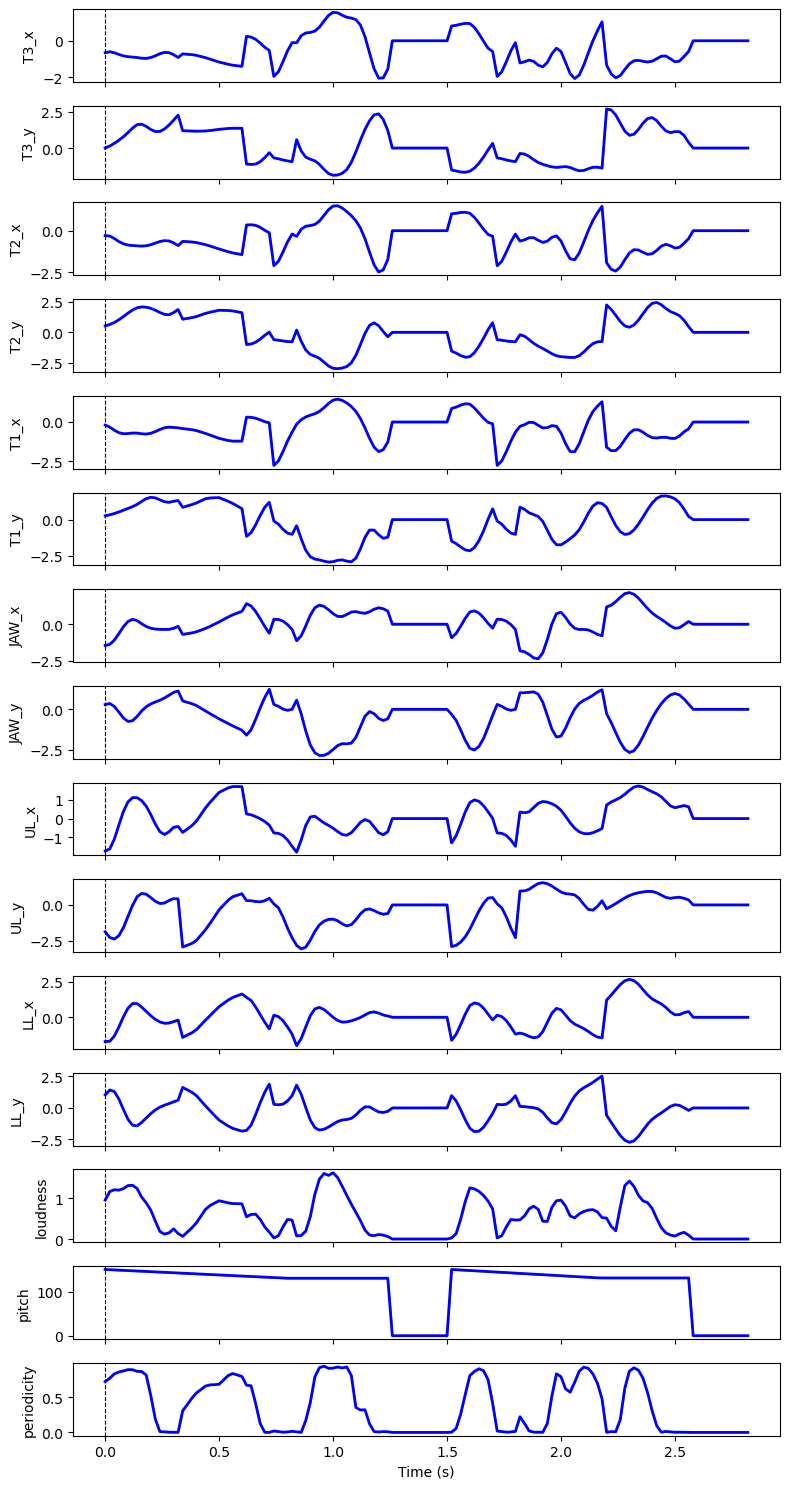

In [170]:

plot_segments(ema_utt_da)

c1 = ema_da_to_sparc_code(ema_utt_da)
wav = coder.decode(**c1)
Audio(wav, rate=FS_SPARC_AUDIO, autoplay=True)